# Task 3: Depth Optimization Model

## Objective
Maximize cumulative profit for locations A, B, C at horizons: 5, 10, and 15 years

## Decision Variables
- Location: l ∈ {A, B, C}
- Depth: d ∈ [0, 20] km
- Year horizon: y ∈ {5, 10, 15}

## Profit Formula
```
Profit = Σ mass_m,l,d × (price_m,y - cost_l,d - refining_cost_m)
```

## Approach
1. Calculate demand-supply gap for each mineral
2. Select top 4 minerals by gap size
3. Compute profit at each depth for each location/horizon
4. Find optimal depth maximizing cumulative profit


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load all data sheets
xlsx = pd.ExcelFile('Deep Earth Mining Data.xlsx')
df_composition = pd.read_excel(xlsx, sheet_name='Composition')
df_cost = pd.read_excel(xlsx, sheet_name='Cost')
df_market = pd.read_excel(xlsx, sheet_name='Market')
df_refining = pd.read_excel(xlsx, sheet_name='Refining Costs')

# Clean refining data
df_refining = df_refining.rename(columns={'Unnamed: 0': 'Mineral'}).dropna()
refining_dict = dict(zip(df_refining['Mineral'], df_refining['Refining Cost (USD/Ton)']))

print("Data loaded successfully!")
print(f"\nAvailable minerals for refining: {list(refining_dict.keys())}")


Data loaded successfully!

Available minerals for refining: ['Lithium', 'Nickel', 'Cobalt', 'Graphite', 'Manganese', 'Copper', 'RareEarth', 'Zinc', 'Tin', 'Aluminum', 'Iron', 'Lead', 'Silver', 'Gold', 'Platinum', 'Phosphorus', 'Potash', 'Silicon', 'Germanium', 'Gallium', 'Antimony', 'Molybdenum', 'Vanadium', 'Tungsten', 'Selenium', 'Indium', 'Tellurium', 'Bismuth', 'Cadmium', 'Chromium']


## Step 1: Calculate Demand-Supply Gap for Each Mineral

We'll identify the top 4 minerals with the largest demand-supply gaps across all horizons.


In [2]:
# Analyze market data - calculate demand-supply gaps
df_market_clean = df_market.copy()

# Map years to horizons
year_to_horizon = {2030: 5, 2035: 10, 2040: 15}
df_market_clean['Horizon'] = df_market_clean['Year'].map(year_to_horizon)

# Calculate gap (demand - supply)
df_market_clean['Gap'] = df_market_clean["Demand ('000 Tonnes)"] - df_market_clean["Supply ('000 Tonnes)"]

# Clean mineral names to match composition data
df_market_clean['Mineral_Clean'] = df_market_clean['Mineral'].str.replace(' (Million Tonnes)', '', regex=False)
df_market_clean['Mineral_Clean'] = df_market_clean['Mineral_Clean'].str.strip()

# Display gaps by horizon
print("=== Demand-Supply Gaps by Horizon ('000 Tonnes) ===\n")
gap_pivot = df_market_clean.pivot_table(values='Gap', index='Mineral_Clean', columns='Horizon', aggfunc='first')
print(gap_pivot.round(2))

# Calculate average gap across all horizons
avg_gaps = df_market_clean.groupby('Mineral_Clean')['Gap'].mean().sort_values(ascending=False)
print("\n=== Average Gap Ranking ===")
print(avg_gaps.round(2))


=== Demand-Supply Gaps by Horizon ('000 Tonnes) ===

Horizon                       5      10     15
Mineral_Clean                                 
Aluminum ('000 Mil tonnes)  0.06  -0.07  -0.32
Antimony                    0.01   0.02  -0.11
Bismuth                     0.05  -0.08  -0.02
Cadmium                     0.03   0.05  -0.12
Chromium                   -0.14  -0.18   0.02
Cobalt                      3.90  10.12  12.05
Copper (Million Tones)      4.37  13.27  14.98
Gallium                    -0.12  -0.16  -0.14
Germanium                  -0.02  -0.09   0.24
Gold (per Kg)              -0.06  -0.07  -0.16
Graphite                   -0.04  -0.06  -0.14
Indium                      0.04  -0.02  -0.23
Iron ('000 mil ton)         0.01  -0.01  -0.07
Lead                       -0.12  -0.18  -0.07
Lithium                     4.71   9.88   9.99
Manganese                   0.03  -0.02   0.04
Molybdenum                  0.18  -0.13  -0.09
Nickel                      0.07   0.02   0.16
Phospho

🎯 Top 4 Minerals Selected: ['Copper (Million Tones)', 'Cobalt', 'Lithium', 'RareEarth']


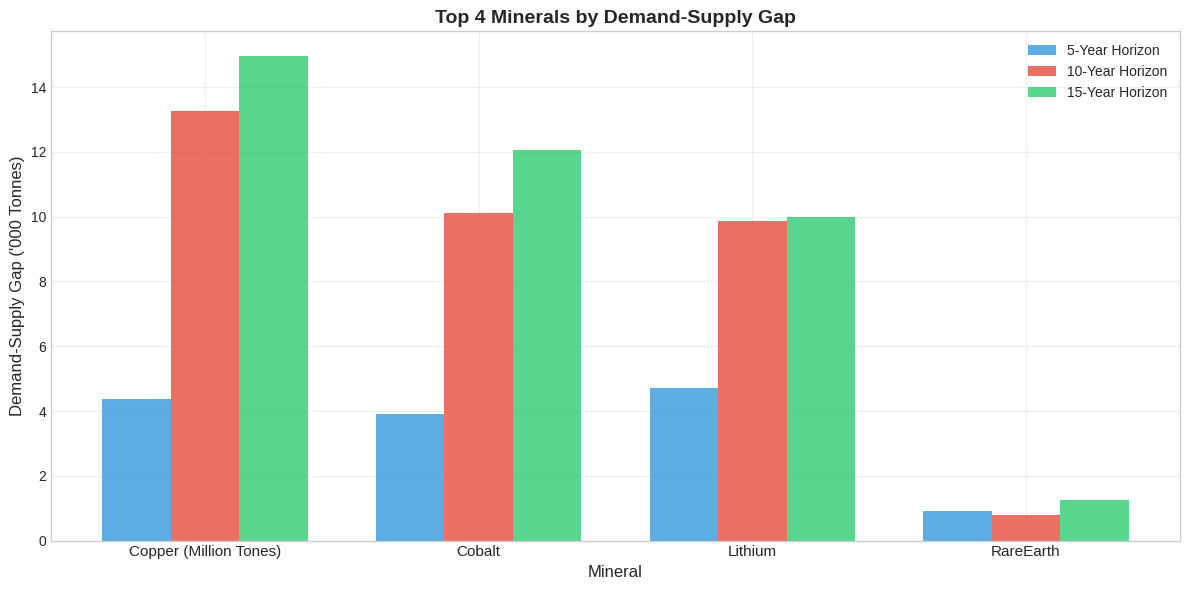

In [3]:
# Select top 4 minerals by average demand-supply gap
top_4_minerals = avg_gaps.head(4).index.tolist()
print(f"🎯 Top 4 Minerals Selected: {top_4_minerals}")

# Visualize gaps for top minerals
fig, ax = plt.subplots(figsize=(12, 6))

# Filter for top 4 minerals
df_top4 = df_market_clean[df_market_clean['Mineral_Clean'].isin(top_4_minerals)]

# Create grouped bar chart
x = np.arange(len(top_4_minerals))
width = 0.25
horizons = [5, 10, 15]
colors = ['#3498db', '#e74c3c', '#2ecc71']

for i, horizon in enumerate(horizons):
    gaps = [df_top4[(df_top4['Mineral_Clean'] == m) & (df_top4['Horizon'] == horizon)]['Gap'].values[0]
            if len(df_top4[(df_top4['Mineral_Clean'] == m) & (df_top4['Horizon'] == horizon)]) > 0 else 0
            for m in top_4_minerals]
    ax.bar(x + i*width, gaps, width, label=f'{horizon}-Year Horizon', color=colors[i], alpha=0.8)

ax.set_xlabel('Mineral', fontsize=12)
ax.set_ylabel("Demand-Supply Gap ('000 Tonnes)", fontsize=12)
ax.set_title('Top 4 Minerals by Demand-Supply Gap', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(top_4_minerals, fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 2: Prepare Composition and Cost Data

Clean and structure the data for profit calculations.


In [4]:
# Clean composition data - extract location-specific data
df_comp_clean = df_composition.copy()

# The first row is a header descriptor, skip it
df_comp_clean = df_comp_clean.iloc[1:].reset_index(drop=True)

# Forward fill the Location column
df_comp_clean['Location'] = df_comp_clean['Location'].fillna(method='ffill')

# Convert Depth_km to numeric
df_comp_clean['Depth_km'] = pd.to_numeric(df_comp_clean['Depth_km'], errors='coerce')

# Get mineral columns (exclude metadata columns)
metadata_cols = ['Location', 'Depth_km', 'Moisture Content (%)', 'Thermal Gradient (°C/km)', 'Crust Porosity (%)']
mineral_cols = [col for col in df_comp_clean.columns if col not in metadata_cols]

print(f"Total minerals in composition data: {len(mineral_cols)}")
print(f"Minerals: {mineral_cols[:10]}...")  # Show first 10

# Clean cost data
df_cost_clean = df_cost.dropna(subset=['Depth_km']).copy()
cost_col = "Total Extraction Cost ('000 USD/ton)"

print(f"\nLocations in composition: {df_comp_clean['Location'].unique()}")
print(f"Depth range: {df_comp_clean['Depth_km'].min()} - {df_comp_clean['Depth_km'].max()} km")


Total minerals in composition data: 30
Minerals: ['Lithium', 'Nickel', 'Cobalt', 'Graphite', 'Manganese', 'Copper', 'RareEarth', 'Zinc', 'Tin', 'Aluminum']...

Locations in composition: ['Location A' 'Location B' 'Location C']
Depth range: 0.0 - 20.0 km


/tmp/ipython-input-3999899787.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_comp_clean['Location'] = df_comp_clean['Location'].fillna(method='ffill')


## Step 3: Build Profit Calculation Function

For each location, depth, and horizon, calculate:
```
Profit = Σ (composition_% × price_per_ton) - extraction_cost - Σ (composition_% × refining_cost)
```

**Note**: We compute profit per ton of ore extracted. Composition is in weight %, so we multiply by price/refining cost accordingly.


In [5]:
# Create price lookup by mineral and horizon
price_lookup = {}
for _, row in df_market_clean.iterrows():
    mineral = row['Mineral_Clean']
    horizon = row['Horizon']
    price = row['Price_USD_per_ton']
    if pd.notna(horizon) and pd.notna(price):
        price_lookup[(mineral, int(horizon))] = price

print("Sample prices (USD/ton):")
for key in list(price_lookup.keys())[:5]:
    print(f"  {key}: ${price_lookup[key]:,.0f}")

# Map composition column names to market mineral names
# Some adjustments needed for naming consistency
mineral_name_map = {
    'Lithium': 'Lithium',
    'Nickel': 'Nickel',
    'Cobalt': 'Cobalt',
    'Graphite': 'Graphite',
    'Manganese': 'Manganese',
    'Copper': 'Copper',
    'RareEarth': 'RareEarth',
    'Zinc': 'Zinc',
    'Tin': 'Tin',
    'Aluminum': 'Aluminum',
    'Iron': 'Iron',
    'Lead': 'Lead',
    'Silver': 'Silver',
    'Gold': 'Gold',
    'Platinum': 'Platinum'
}

print(f"\nTop 4 minerals for optimization: {top_4_minerals}")


Sample prices (USD/ton):
  ('Lithium', 5): $82,169
  ('Lithium', 10): $125,009
  ('Lithium', 15): $156,413
  ('Nickel', 5): $17,305
  ('Nickel', 10): $28,113

Top 4 minerals for optimization: ['Copper (Million Tones)', 'Cobalt', 'Lithium', 'RareEarth']


In [6]:
def calculate_profit_per_ton(location, depth, horizon, minerals_to_use):
    """
    Calculate profit per ton of ore extracted at given location, depth, and horizon.
    Only considers specified minerals.

    Returns profit in USD per ton of ore.
    """
    # Get composition at this location and depth
    comp_row = df_comp_clean[(df_comp_clean['Location'] == location) &
                              (df_comp_clean['Depth_km'] == depth)]
    if len(comp_row) == 0:
        return None
    comp_row = comp_row.iloc[0]

    # Get extraction cost at this location and depth (in '000 USD/ton)
    cost_row = df_cost_clean[(df_cost_clean['Location'] == location) &
                              (df_cost_clean['Depth_km'] == depth)]
    if len(cost_row) == 0:
        return None
    extraction_cost = cost_row[cost_col].values[0] * 1000  # Convert to USD/ton

    # Calculate revenue and refining cost for each mineral
    total_revenue = 0
    total_refining_cost = 0

    for mineral in minerals_to_use:
        # Get composition percentage
        if mineral in comp_row.index:
            comp_pct = comp_row[mineral]
            if pd.isna(comp_pct):
                comp_pct = 0
        else:
            comp_pct = 0

        # Get price for this mineral at this horizon
        price = price_lookup.get((mineral, horizon), 0)

        # Get refining cost for this mineral
        refining_cost = refining_dict.get(mineral, 0)

        # Revenue from this mineral (composition% * price per ton of pure mineral)
        # composition is in %, so divide by 100
        mineral_revenue = (comp_pct / 100) * price
        mineral_refining = (comp_pct / 100) * refining_cost

        total_revenue += mineral_revenue
        total_refining_cost += mineral_refining

    # Profit = Revenue - Extraction Cost - Refining Cost
    profit = total_revenue - extraction_cost - total_refining_cost

    return profit

# Test the function
test_profit = calculate_profit_per_ton('Location A', 5, 10, top_4_minerals)
print(f"Test profit at Location A, Depth 5km, 10-year horizon: ${test_profit:,.2f}/ton")


Test profit at Location A, Depth 5km, 10-year horizon: $-1,560,698.66/ton


## Step 4: Find Optimal Depth for Each Location and Horizon

Iterate through all depths (0-20 km) and find the depth that maximizes profit.


In [7]:
# Calculate profit at all depths for all locations and horizons
locations = ['Location A', 'Location B', 'Location C']
horizons = [5, 10, 15]
depths = list(range(0, 21))  # 0 to 20 km

# Store results
results = []
profit_matrix = {}

for location in locations:
    profit_matrix[location] = {}
    for horizon in horizons:
        profit_matrix[location][horizon] = []
        for depth in depths:
            profit = calculate_profit_per_ton(location, depth, horizon, top_4_minerals)
            if profit is not None:
                profit_matrix[location][horizon].append({'depth': depth, 'profit': profit})
                results.append({
                    'Location': location,
                    'Horizon': horizon,
                    'Depth_km': depth,
                    'Profit_per_ton': profit
                })

df_results = pd.DataFrame(results)

# Find optimal depth for each location-horizon combination
print("=" * 60)
print("OPTIMAL DEPTH SELECTION RESULTS")
print("=" * 60)

optimal_results = []
for location in locations:
    for horizon in horizons:
        subset = df_results[(df_results['Location'] == location) &
                           (df_results['Horizon'] == horizon)]
        if len(subset) > 0:
            max_idx = subset['Profit_per_ton'].idxmax()
            optimal = subset.loc[max_idx]
            optimal_results.append({
                'Location': location,
                'Horizon (Years)': horizon,
                'Optimal Depth (km)': optimal['Depth_km'],
                'Profit (USD/ton)': optimal['Profit_per_ton']
            })
            print(f"\n{location} | {horizon}-Year Horizon:")
            print(f"  Optimal Depth: {optimal['Depth_km']} km")
            print(f"  Profit: ${optimal['Profit_per_ton']:,.2f}/ton")

df_optimal = pd.DataFrame(optimal_results)
print("\n" + "=" * 60)


OPTIMAL DEPTH SELECTION RESULTS

Location A | 5-Year Horizon:
  Optimal Depth: 0 km
  Profit: $-307,024.03/ton

Location A | 10-Year Horizon:
  Optimal Depth: 0 km
  Profit: $-306,161.12/ton

Location A | 15-Year Horizon:
  Optimal Depth: 0 km
  Profit: $-305,377.47/ton

Location B | 5-Year Horizon:
  Optimal Depth: 0 km
  Profit: $-248,168.10/ton

Location B | 10-Year Horizon:
  Optimal Depth: 0 km
  Profit: $-247,092.48/ton

Location B | 15-Year Horizon:
  Optimal Depth: 0 km
  Profit: $-246,207.32/ton

Location C | 5-Year Horizon:
  Optimal Depth: 0 km
  Profit: $-279,470.67/ton

Location C | 10-Year Horizon:
  Optimal Depth: 0 km
  Profit: $-278,990.24/ton

Location C | 15-Year Horizon:
  Optimal Depth: 0 km
  Profit: $-278,500.19/ton



/tmp/ipython-input-3738640705.py:32: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


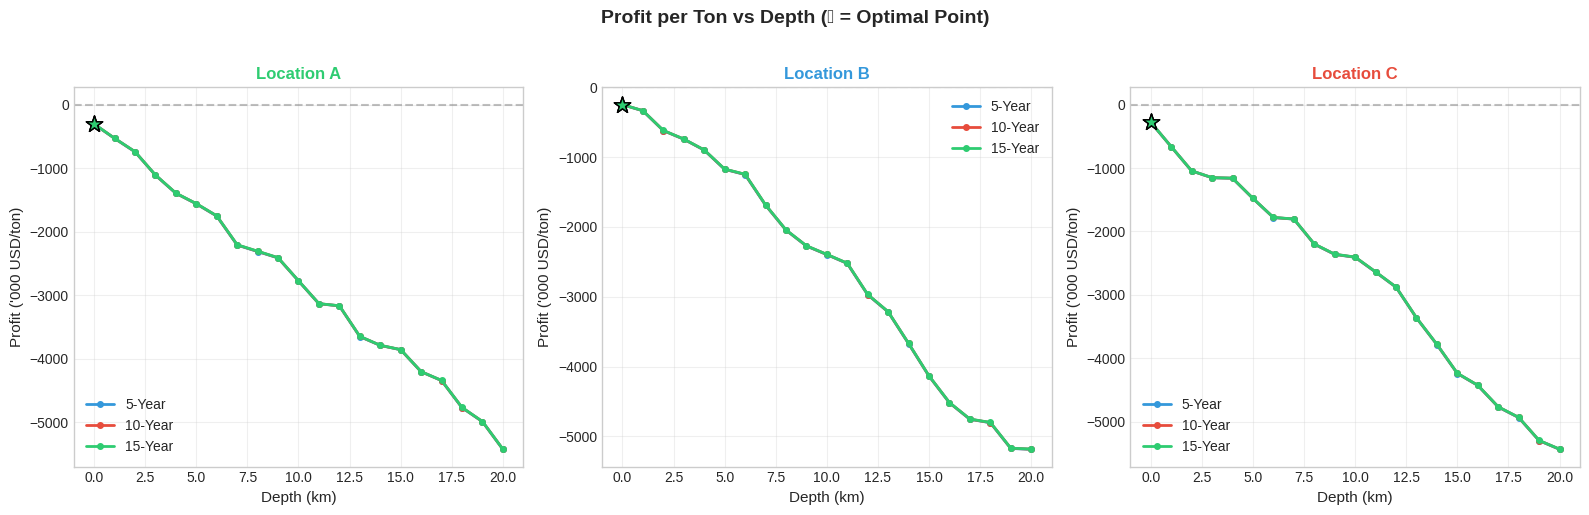

In [8]:
# Visualize profit curves by depth for each location
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

colors = {'5': '#3498db', '10': '#e74c3c', '15': '#2ecc71'}
location_colors = ['#2ecc71', '#3498db', '#e74c3c']

for idx, (ax, location) in enumerate(zip(axes, locations)):
    for horizon in horizons:
        subset = df_results[(df_results['Location'] == location) &
                           (df_results['Horizon'] == horizon)].sort_values('Depth_km')
        ax.plot(subset['Depth_km'], subset['Profit_per_ton']/1000,
                marker='o', linewidth=2, markersize=4,
                label=f'{horizon}-Year', color=colors[str(horizon)])

        # Mark optimal point
        opt = df_optimal[(df_optimal['Location'] == location) &
                        (df_optimal['Horizon (Years)'] == horizon)]
        if len(opt) > 0:
            ax.scatter(opt['Optimal Depth (km)'].values[0],
                      opt['Profit (USD/ton)'].values[0]/1000,
                      s=150, marker='*', color=colors[str(horizon)],
                      edgecolors='black', zorder=5)

    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Depth (km)', fontsize=11)
    ax.set_ylabel("Profit ('000 USD/ton)", fontsize=11)
    ax.set_title(location, fontsize=12, fontweight='bold', color=location_colors[idx])
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Profit per Ton vs Depth (★ = Optimal Point)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## Summary: Optimal Depth Selection Results

The table below shows the optimal mining depth for each location and time horizon:


=== OPTIMAL DEPTH (km) BY LOCATION AND HORIZON ===

Horizon (Years)  5   10  15
Location                   
Location A        0   0   0
Location B        0   0   0
Location C        0   0   0

=== PROFIT AT OPTIMAL DEPTH (USD/ton) ===

Horizon (Years)         5          10         15
Location                                        
Location A      -307024.03 -306161.12 -305377.47
Location B      -248168.10 -247092.48 -246207.32
Location C      -279470.67 -278990.24 -278500.19

✅ Results saved to 'task3_optimal_depths.csv' for use in Task 4


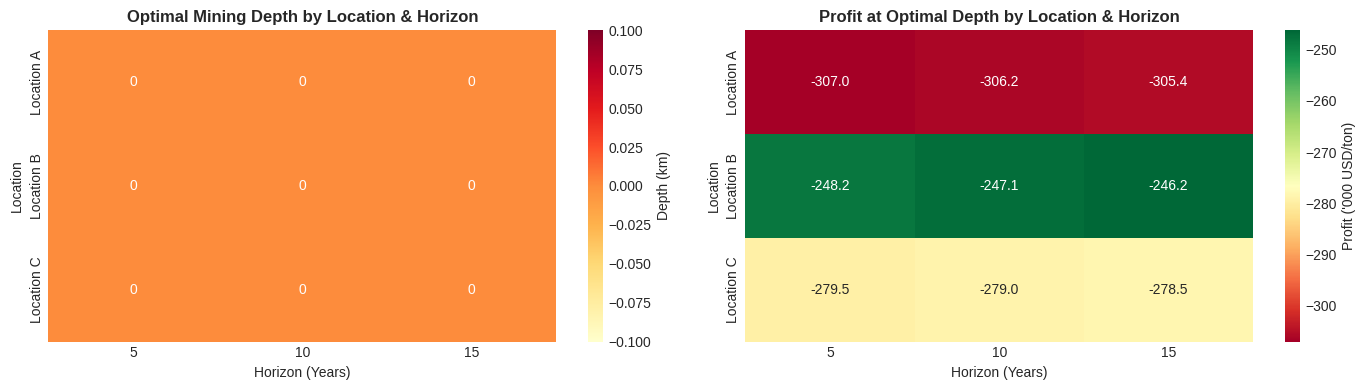


📊 Key Insight: Top 4 minerals used: ['Copper (Million Tones)', 'Cobalt', 'Lithium', 'RareEarth']


In [9]:
# Create summary pivot table
summary_pivot = df_optimal.pivot(index='Location', columns='Horizon (Years)',
                                  values='Optimal Depth (km)')
print("=== OPTIMAL DEPTH (km) BY LOCATION AND HORIZON ===\n")
print(summary_pivot)

# Also show profit at optimal depths
profit_pivot = df_optimal.pivot(index='Location', columns='Horizon (Years)',
                                 values='Profit (USD/ton)')
print("\n=== PROFIT AT OPTIMAL DEPTH (USD/ton) ===\n")
print(profit_pivot.round(2))

# Save optimal results for Task 4
df_optimal.to_csv('task3_optimal_depths.csv', index=False)
print("\n✅ Results saved to 'task3_optimal_depths.csv' for use in Task 4")

# Heatmap visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Optimal depth heatmap
sns.heatmap(summary_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[0],
            cbar_kws={'label': 'Depth (km)'})
axes[0].set_title('Optimal Mining Depth by Location & Horizon', fontsize=12, fontweight='bold')

# Profit heatmap
sns.heatmap(profit_pivot/1000, annot=True, fmt='.1f', cmap='RdYlGn', ax=axes[1],
            cbar_kws={'label': "Profit ('000 USD/ton)"})
axes[1].set_title('Profit at Optimal Depth by Location & Horizon', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Key Insight: Top 4 minerals used: {top_4_minerals}")
